In [1]:
import os
import shutil
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import scipy.io.wavfile as wavfile
import scipy.signal as signal

from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score
from tensorflow.keras import layers, models

2024-06-30 14:34:15.495790: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-30 14:34:15.495914: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-30 14:34:15.643403: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
FILE_PATH = '/kaggle/input/infant-cry-audio-corpus/donateacry_corpus'
dataset = pathlib.Path(FILE_PATH)
cry_list = np.array(tf.io.gfile.listdir(str(dataset)))
print(cry_list) 

['hungry' 'burping' 'discomfort' 'belly_pain' 'tired']


Rebalancing

In [3]:
# target number of samples per class
TARGET_COUNT = 30

class_files = {cry: list((dataset / cry).glob('*.wav')) for cry in cry_list}
class_counts = {cry: len(files) for cry, files in class_files.items()}
print(class_counts)

{'hungry': 382, 'burping': 8, 'discomfort': 27, 'belly_pain': 16, 'tired': 24}


In [4]:
# new directory for the rebalanced dataset
rebalance_dataset_path = '/kaggle/working/rebalanced_dataset'
os.makedirs(rebalance_dataset_path, exist_ok=True)

# duplicate files to reach the target count
def duplicate_files(class_name, files, target_count, save_dir):
    current_count = len(files)
    index = 0
    while current_count < target_count:
        file_to_copy = files[index % len(files)]
        filename = file_to_copy.stem + f'_dup{index // len(files)}.wav'
        save_path = os.path.join(save_dir, filename)
        shutil.copy(file_to_copy, save_path)
        current_count += 1
        index += 1

def trim_files(files, target_count, save_dir):
    files_to_keep = files[:target_count]
    for file in files_to_keep:
        shutil.copy(file, save_dir)

# copy original files and duplicate / trim
for class_name, files in class_files.items():
    class_dir = os.path.join(rebalance_dataset_path, class_name)
    os.makedirs(class_dir, exist_ok=True)
    if class_name == 'hungry':
        # trim 'hungry'
        trim_files(files, TARGET_COUNT, class_dir)
    elif len(files) > TARGET_COUNT:
        # trim if more than TARGET_COUNT
        trim_files(files, TARGET_COUNT, class_dir)
    else:
        # copy original files
        for file in files:
            shutil.copy(file, class_dir)
        # duplicate files to reach target count
        duplicate_files(class_name, files, TARGET_COUNT, class_dir)

rebalance_class_files = {cry: list(pathlib.Path(rebalance_dataset_path).glob(f'{cry}/*.wav')) for cry in cry_list}
rebalance_class_counts = {cry: len(files) for cry, files in rebalance_class_files.items()}
print("Rebalanced Class Counts:", rebalance_class_counts)

Rebalanced Class Counts: {'hungry': 30, 'burping': 30, 'discomfort': 30, 'belly_pain': 30, 'tired': 30}


In [5]:
train_set, val_set = tf.keras.utils.audio_dataset_from_directory(
    directory=rebalance_dataset_path, # new rebalanced data directory
    batch_size=16,
    seed=0,
    validation_split=.2,
    output_sequence_length=16000,
    subset='both'
)

label_names = np.array(train_set.class_names)
print(label_names)
print(len(train_set))
print(len(val_set))

Found 150 files belonging to 5 classes.
Using 120 files for training.
Using 30 files for validation.
['belly_pain' 'burping' 'discomfort' 'hungry' 'tired']
8
2


In [6]:
def squeeze(audio, label):
    audio=tf.squeeze(audio, axis=-1)
    return audio, label

train_set = train_set.map(squeeze, tf.data.AUTOTUNE)
val_set = val_set.map(squeeze, tf.data.AUTOTUNE)

test_set = val_set.shard(num_shards=2, index=0)
val_set = val_set.shard(num_shards=2, index=1)

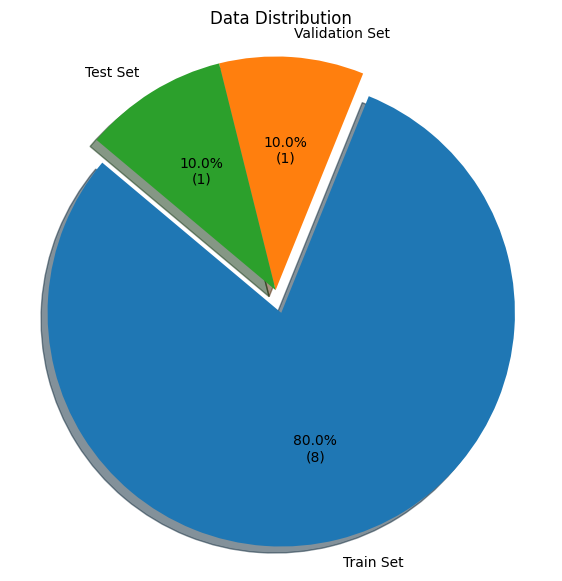

In [7]:
train_samples = len(list(train_set))
val_samples = len(list(val_set))
test_samples = len(list(test_set))

labels = ['Train Set', 'Validation Set', 'Test Set']
sizes = [train_samples, val_samples, test_samples]
explode = (0.1, 0, 0) 

def autopct_format(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return f"{pct:.1f}%\n({absolute})"

plt.figure(figsize=(7, 7))
plt.pie(sizes, explode=explode, labels=labels, autopct=lambda pct: autopct_format(pct, sizes), shadow=True, startangle=140)
plt.axis('equal')  
plt.title('Data Distribution')
plt.show()

In [8]:
def get_spectogram(waveform):
    spectogram=tf.signal.stft(
        signals=waveform,
        frame_length=255,
        frame_step=128
    )
    spectogram=tf.abs(spectogram)
    spectogram=spectogram[..., tf.newaxis]
    return spectogram

def make_spectogram_ds(ds):
    return ds.map(
        map_func=lambda audio, label: (get_spectogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE
    )

In [9]:
def plot_waveform(waveform, title='Waveform'):
    plt.figure(figsize=(10, 4))
    plt.plot(waveform)
    plt.title(title)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()
    
def plot_spectrogram(spectrogram, title='Spectrogram'):
    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram, aspect='auto', origin='lower', cmap='inferno')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

def plot_frequency_distribution(waveform, sr, title='Frequency Distribution'):
    f, Pxx_den = signal.periodogram(waveform, sr)
    plt.figure(figsize=(10, 4))
    plt.semilogy(f, Pxx_den)
    plt.title(title)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.show()

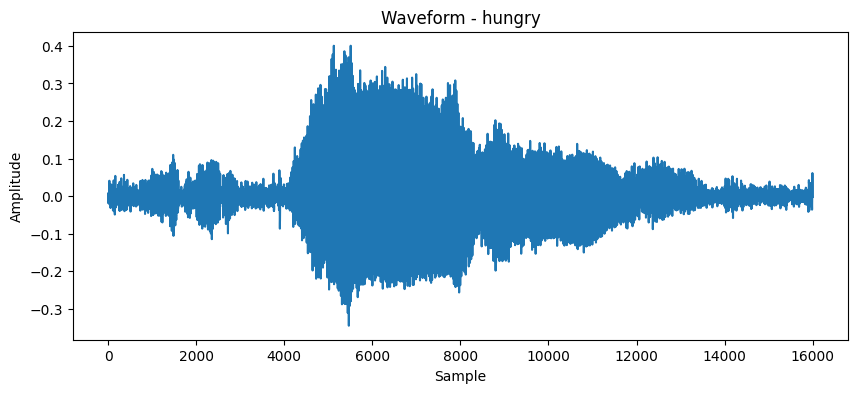

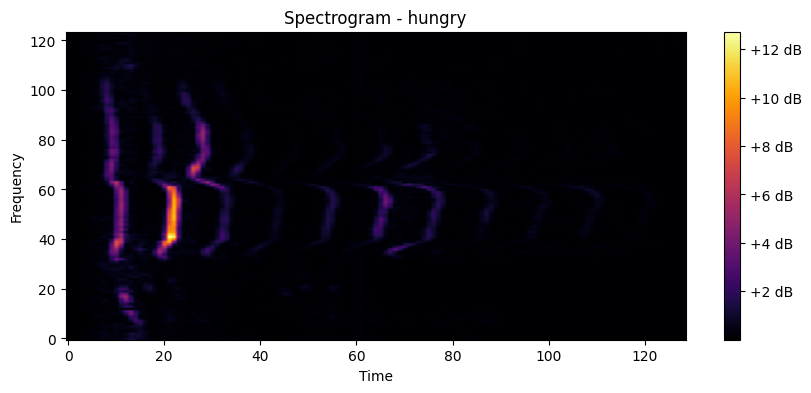

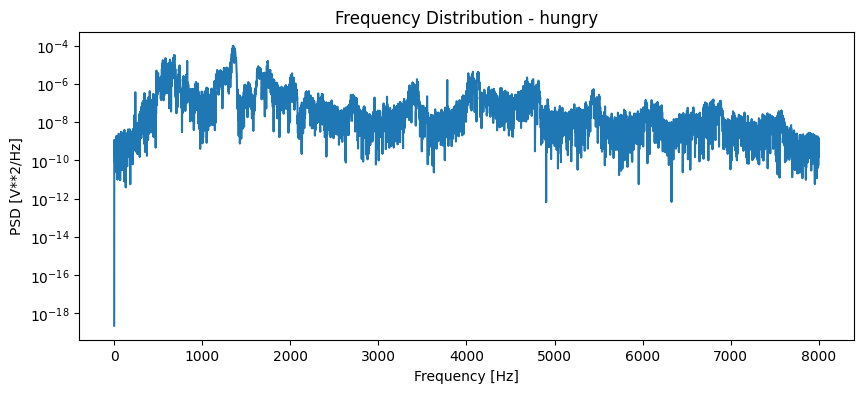

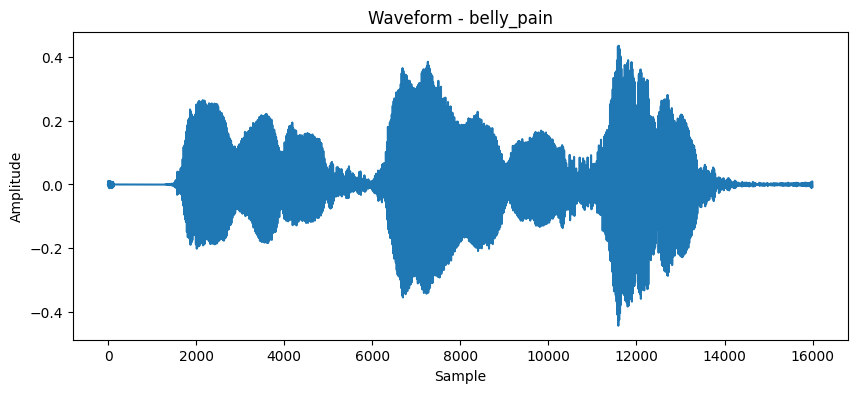

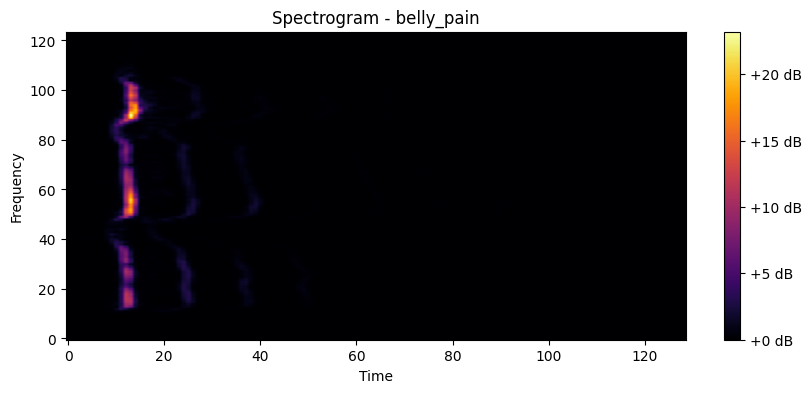

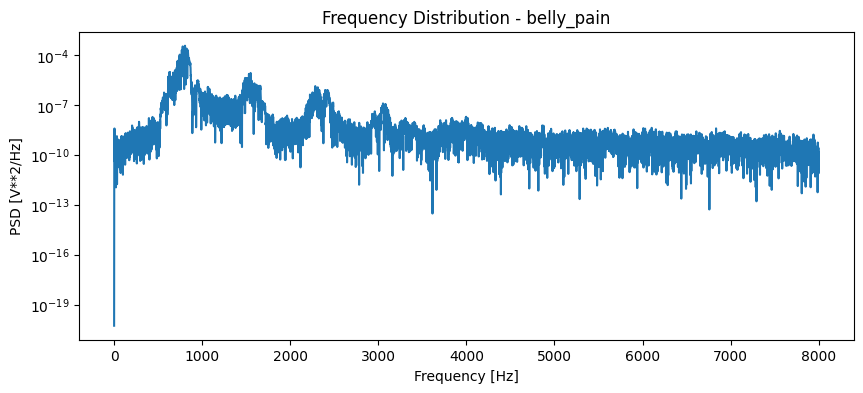

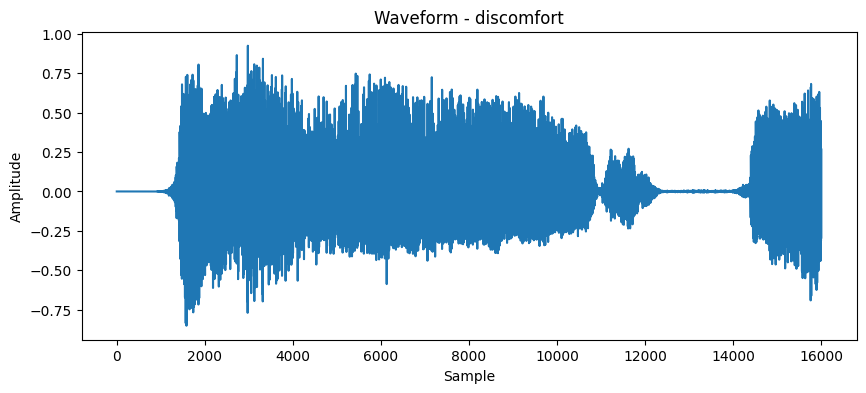

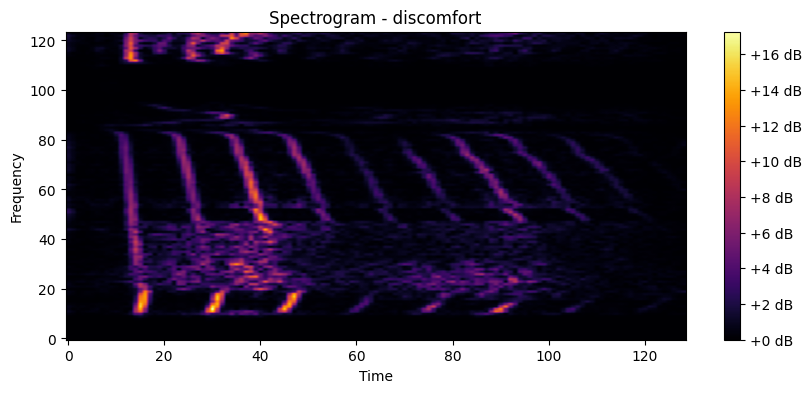

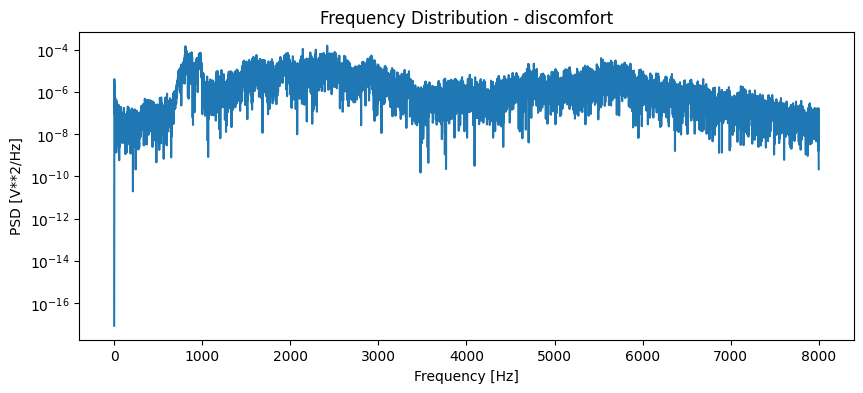

In [10]:
for audio, label in train_set.take(1):
    for i in range(3): 
        waveform = audio[i].numpy()
        label_str = label_names[label[i].numpy()]

        plot_waveform(waveform, title=f'Waveform - {label_str}')

        spectrogram = get_spectogram(waveform).numpy()
        spectrogram = np.squeeze(spectrogram)  
        plot_spectrogram(spectrogram, title=f'Spectrogram - {label_str}')

        plot_frequency_distribution(waveform, sr=16000, title=f'Frequency Distribution - {label_str}')

In [11]:
train_set_spec = make_spectogram_ds(train_set).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_set_spec = make_spectogram_ds(val_set).cache().prefetch(tf.data.AUTOTUNE)
test_set_spec = make_spectogram_ds(test_set).cache().prefetch(tf.data.AUTOTUNE)

In [12]:
for example_case, example_case_label in train_set_spec.take(1):
    break

In [13]:
input_shape = example_case.shape[1:]
num_label = len(cry_list)
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_set_spec.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(.5),
    layers.Dense(num_label)
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,224 (6.20 MB)

 Trainable params: 1,625,221 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [15]:
history = model.fit(
    train_set_spec,
    validation_data=val_set_spec,
    epochs=10,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=3, verbose=3)
)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.2613 - loss: 1.6191 - val_accuracy: 0.4286 - val_loss: 1.2906
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3644 - loss: 1.5005 - val_accuracy: 0.4286 - val_loss: 1.2726
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4593 - loss: 1.2850 - val_accuracy: 0.5000 - val_loss: 1.2964
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5603 - loss: 1.0917 - val_accuracy: 0.5000 - val_loss: 1.2935
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6468 - loss: 0.9133 - val_accuracy: 0.6429 - val_loss: 1.2561
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6662 - loss: 0.8250 - val_accuracy: 0.6429 - val_loss: 1.2849
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7227 - loss: 0.6775 - val_accuracy: 0.6429 - val_loss: 1.2817
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7870 - loss: 0.5614 - val_accuracy: 0.6429 - val_loss: 1.1565


In [16]:
model.save('cry_classification_model.h5')

In [17]:
ctr=0
for i , (spectogram, label) in enumerate(test_set_spec):
    pred = model.predict(spectogram)
    pred_label_idx = tf.argmax(pred, axis=1).numpy()
    orig_label = label_names[label.numpy()]
    pred_label = [label_names[idx] for idx in pred_label_idx]
    for j, label in enumerate(orig_label):
        ctr+=1
        print(f'Data-{ctr}: label: {label} -> predicted: {pred_label[j]}') 
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Data-1: label: belly_pain -> predicted: belly_pain
Data-2: label: tired -> predicted: tired
Data-3: label: belly_pain -> predicted: belly_pain
Data-4: label: belly_pain -> predicted: belly_pain
Data-5: label: tired -> predicted: hungry
Data-6: label: burping -> predicted: burping
Data-7: label: tired -> predicted: tired
Data-8: label: hungry -> predicted: tired
Data-9: label: discomfort -> predicted: discomfort
Data-10: label: discomfort -> predicted: discomfort
Data-11: label: hungry -> predicted: hungry
Data-12: label: tired -> predicted: tired
Data-13: label: discomfort -> predicted: tired
Data-14: label: discomfort -> predicted: discomfort
Data-15: label: belly_pain -> predicted: belly_pain
Data-16: label: discomfort -> predicted: discomfort


In [18]:
test_result = model.evaluate(test_set_spec, return_dict=True)
accuracy = test_result['accuracy']
print(f"Accuracy = {round(accuracy * 100, 2)}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8125 - loss: 0.9763
Accuracy = 81.25%


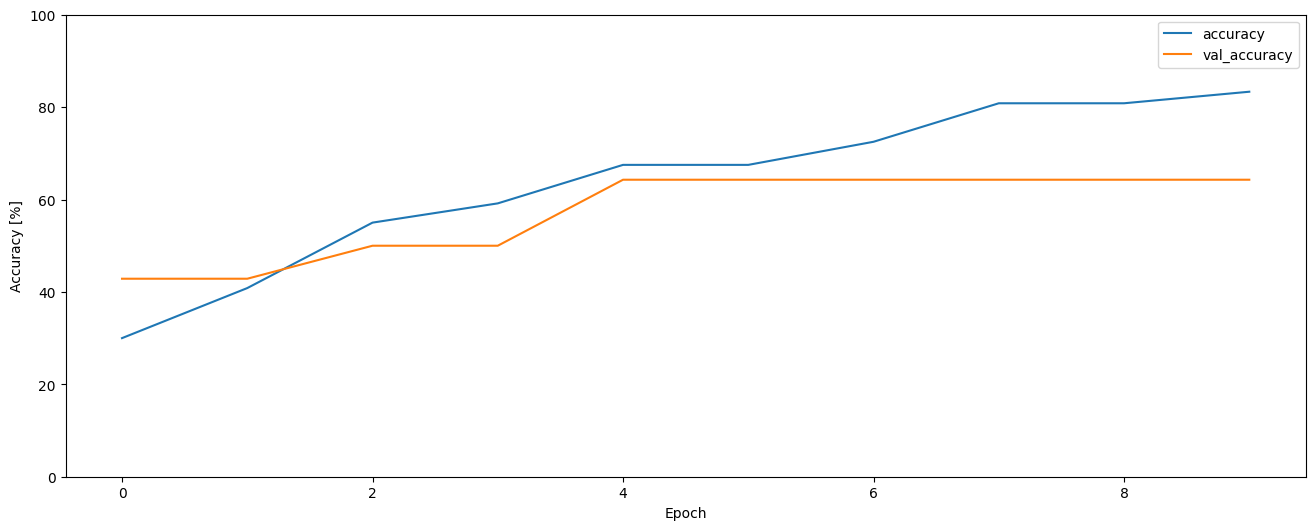

In [19]:
metrics = history.history
plt.figure(figsize=(16, 6))
plt.plot(history.epoch, 100 * np.array(metrics['accuracy']), 100 * np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.show()

In [20]:
y_true = []
y_pred = []

for spectogram, label in test_set_spec:
    pred = model.predict(spectogram)
    pred_label_idx = tf.argmax(pred, axis=1).numpy()
    y_true.extend(label.numpy())
    y_pred.extend(pred_label_idx)

y_true_names = [label_names[idx] for idx in y_true]
y_pred_names = [label_names[idx] for idx in y_pred]

precision = precision_score(y_true_names, y_pred_names, average='weighted')
recall = recall_score(y_true_names, y_pred_names, average='weighted')

print(f"Precision = {round(precision * 100, 2)}%")
print(f"Recall = {round(recall * 100, 2)}%")
print("Classification Report:")
print(classification_report(y_true_names, y_pred_names, labels=label_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Precision = 83.75%
Recall = 81.25%
Classification Report:
              precision    recall  f1-score   support

  belly_pain       1.00      1.00      1.00         4
     burping       1.00      1.00      1.00         1
  discomfort       1.00      0.80      0.89         5
      hungry       0.50      0.50      0.50         2
       tired       0.60      0.75      0.67         4

    accuracy                           0.81        16
   macro avg       0.82      0.81      0.81        16
weighted avg       0.84      0.81      0.82        16



Confusion Matrix:


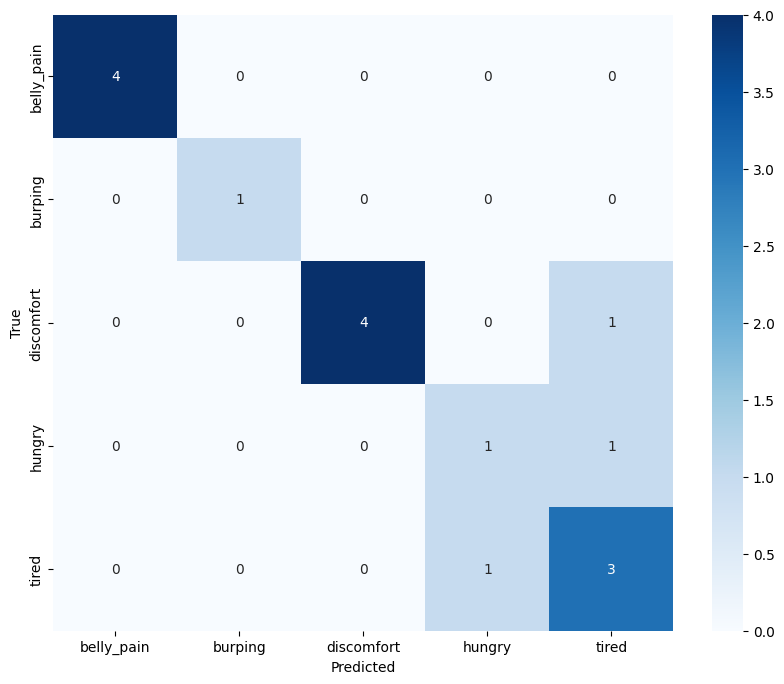

In [21]:
print("Confusion Matrix:")
cm = confusion_matrix(y_true_names, y_pred_names, labels=label_names)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()